In [1]:
import pandas as pd
from datetime import datetime as dt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup as BS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
from ipywidgets import interact, FloatSlider, IntSlider
from matplotlib.ticker import MaxNLocator

In [2]:
data= pd.read_csv('fullsample-corrected.csv', chunksize=100000)

In [3]:
datachunk1 = next(data)

In [5]:
datachunk1.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,TIMEOUT,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:15
2,30858137,TIMEOUT,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:15
3,30935078,TIMEOUT,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:15
4,31364111_2,TIMEOUT,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:9


In [6]:
#removing 'Unknown' from END so that we can turn it into a datetime
datachunk1= datachunk1[datachunk1['END']!= 'Unknown']

In [7]:
# spliting the dates into components and turning it to datetime
datachunk1[['START_DATE', 'START_TIME']]= datachunk1['BEGIN'].str.split('T', 1, expand=True)

datachunk1[['START_YEAR', 'START_MONTH', 'START_DAY']]= datachunk1['START_DATE'].str.split('-', 2, expand=True)

datachunk1[['START_HOUR', 'START_MINUTE', 'START_SECOND']]= datachunk1['START_TIME'].str.split(':', 2, expand=True)

datachunk1[['END_DATE', 'END_TIME']]= datachunk1['END'].str.split('T', 1, expand=True)

datachunk1[['END_YEAR', 'END_MONTH', 'END_DAY']]= datachunk1['END_DATE'].str.split('-', 2, expand=True)

datachunk1[['END_HOUR', 'END_MINUTE', 'END_SECOND']]= datachunk1['END_TIME'].str.split(':', 2, expand=True)

datachunk1['START_DATE_TIME']=pd.to_datetime(datachunk1['START_DATE']+ " "+ datachunk1['START_TIME'])

datachunk1['END_DATE_TIME']=pd.to_datetime(datachunk1['END_DATE']+ " "+ datachunk1['END_TIME'])

#changing Begin and end into datetime from object: slurm['DATE']= pd.to_datetime(slurm['DATE'])
datachunk1['BEGIN']= pd.to_datetime(datachunk1["BEGIN"])

datachunk1['END']= pd.to_datetime(datachunk1["END"])

datachunk1['TIME_OF_JOB']=datachunk1['END_DATE_TIME']-datachunk1['START_DATE_TIME']

In [8]:
# job length
datachunk1['jobtime']= datachunk1['END']-datachunk1['BEGIN']

In [9]:
datachunk1_success= datachunk1[datachunk1['STATE']== 'COMPLETED']

In [10]:
datachunk1_success_sort= datachunk1_success.sort_values('BEGIN')

In [11]:
datachunk1_success_sort["rolling_1_hour_average"] = (datachunk1_success_sort.rolling("1h", on = "BEGIN")["EXITCODE"].count())

In [12]:
#df[(df['day'] > '2020-01-15') & (df['day'] < '2020-01-23')].
datachunk1_success_sort_aug=datachunk1_success_sort[datachunk1_success_sort['START_MONTH']=='08']

In [13]:
datachunk1_success_sort_sept=datachunk1_success_sort[datachunk1_success_sort['START_MONTH']=='09']

In [14]:
datachunk1_success_sort['START_MONTH']

5        08
16       08
15       08
14       08
12       08
         ..
92889    09
92891    09
92892    09
541      09
542      09
Name: START_MONTH, Length: 85059, dtype: object

In [15]:
datachunk1_success_sort.columns

Index(['JOBID', 'STATE', 'BEGIN', 'END', 'REQMEM', 'USEDMEM', 'REQTIME',
       'USEDTIME', 'NODES', 'CPUS', 'PARTITION', 'EXITCODE', 'START_DATE',
       'START_TIME', 'START_YEAR', 'START_MONTH', 'START_DAY', 'START_HOUR',
       'START_MINUTE', 'START_SECOND', 'END_DATE', 'END_TIME', 'END_YEAR',
       'END_MONTH', 'END_DAY', 'END_HOUR', 'END_MINUTE', 'END_SECOND',
       'START_DATE_TIME', 'END_DATE_TIME', 'TIME_OF_JOB', 'jobtime',
       'rolling_1_hour_average'],
      dtype='object')

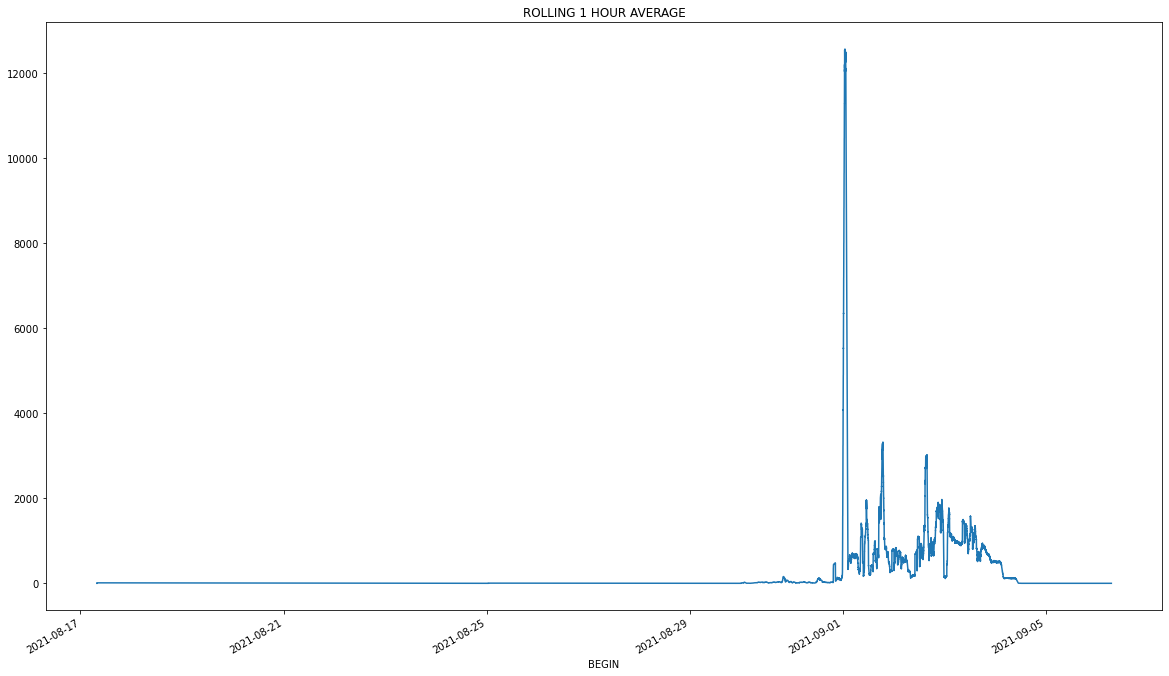

In [16]:
fig, ax = plt.subplots(figsize = (20,12))

datachunk1_success_sort.set_index('BEGIN')['rolling_1_hour_average'].plot(ax = ax)
plt.title('ROLLING 1 HOUR AVERAGE');

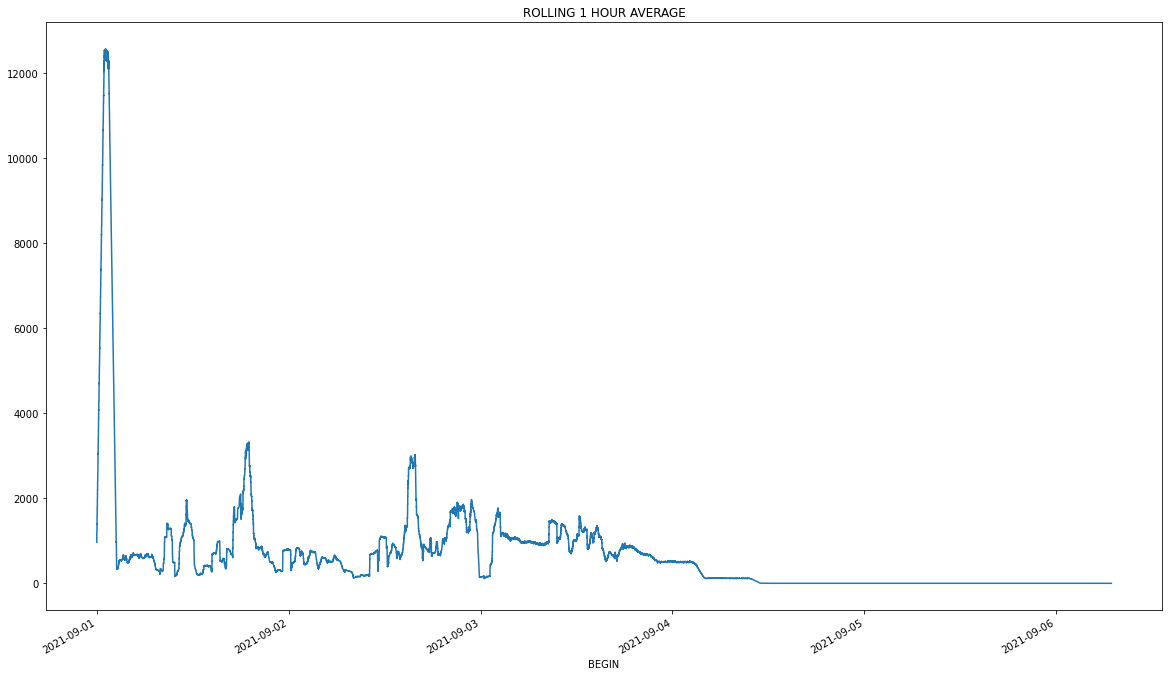

In [17]:
fig, ax = plt.subplots(figsize = (20,12))

datachunk1_success_sort_sept.set_index('BEGIN')['rolling_1_hour_average'].plot(ax = ax)
plt.title('ROLLING 1 HOUR AVERAGE');

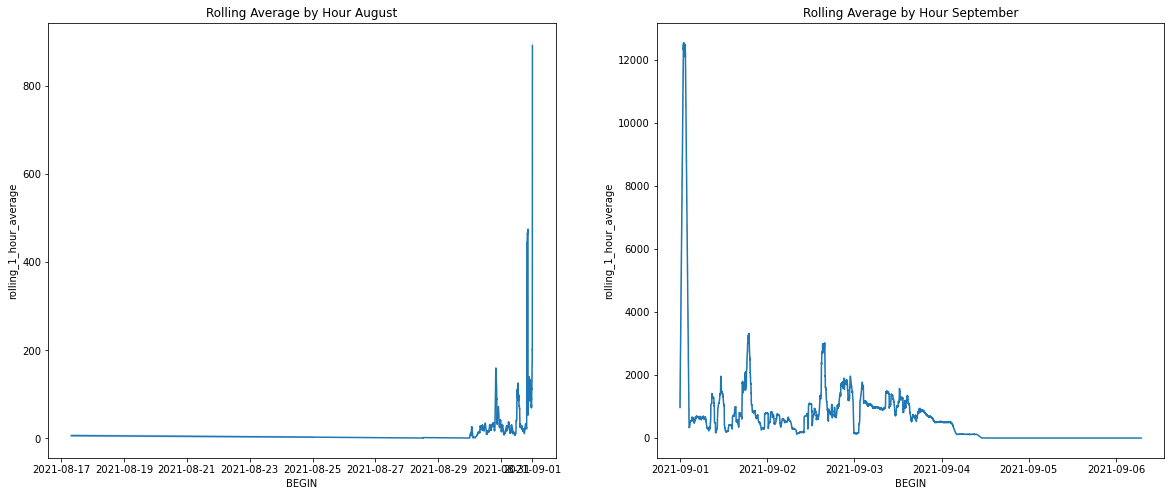

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))

sns.lineplot(data = datachunk1_success_sort_aug.set_index('BEGIN')['rolling_1_hour_average'], 
               palette= ['blue'], ax=ax1)
ax1.title.set_text('Rolling Average by Hour August')


sns.lineplot(data = datachunk1_success_sort_sept.set_index('BEGIN')['rolling_1_hour_average'], 
            palette= ['blue'], ax=ax2)
ax2.title.set_text('Rolling Average by Hour September');


In [ ]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,8))

sns.lineplot(data = datachunk1_success_sort_aug.set_index('BEGIN')['rolling_1_hour_average'], 
               palette= ['blue'], ax=ax1)
ax1.title.set_text('Rolling Average by Hour August')


sns.lineplot(data = datachunk1_success_sort_sept.set_index('BEGIN')['rolling_1_hour_average'], 
            palette= ['blue'], ax=ax2)
ax2.title.set_text('Rolling Average by Hour September');

sns.lineplot(data = datachunk1_success_sort_oct.set_index('BEGIN')['rolling_1_hour_average'], 
            palette= ['blue'], ax=ax3)
ax3.title.set_text('Rolling Average by Hour October');

In [ ]:
fig, (ax1,ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12) = plt.subplots(1,12, figsize=(20,8))

sns.lineplot(data = datachunk1_success_sort_aug.set_index('BEGIN')['rolling_1_hour_average'], 
               palette= ['blue'], ax=ax1)
ax1.title.set_text('Rolling Average by Hour August')


sns.lineplot(data = datachunk1_success_sort_sept.set_index('BEGIN')['rolling_1_hour_average'], 
            palette= ['blue'], ax=ax2)
ax2.title.set_text('Rolling Average by Hour September');
